### Thinking1
参数共享指的是什么？

答：参数共享指在对图像的不同位置进行处理时卷积核的参数都是一样的，故卷积层的参数个数只与卷积核的大小与个数有关，与图像大小无关。

### Thinking2
为什么会用到batch normalization ?

答：在深度学习过程中，随着网络层数的加深，神经元输入的分布可能会逐渐偏移而靠近激活函数定义域的上下限，导致出现梯度消失的情况，致使收敛速度缓慢，而batch normalization将神经元输入值的分布进行正态标准化，使其均值为0方差为1，将其拉回到激活函数较为敏感的区域，从而避免梯度消失问题的产生，加快训练收敛的速度。

### Thinking3
使用dropout可以解决什么问题？

答：dropout在每一个batch训练时，随机地让一部分神经元停止工作，更新完权重后再恢复，这使得模型不会过于依赖某一特征，增强了模型的泛化能力，缓解了过拟合问题。

### Action1
使用任何神经网络框架，对CIFAR-10进行分类
http://www.cs.toronto.edu/~kriz/cifar.html
训练集 50000，测试集 10000
图像大小 32*32 彩色
10个分类：ariplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# 数据加载
train_data = datasets.CIFAR10(root='./cifar10/', train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.CIFAR10(root='./cifar10/', train=False, transform=transforms.ToTensor(), download=True)
print(train_data)
print(test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar10/
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./cifar10/
    Split: Test
    StandardTransform
Transform: ToTensor()


(3, 32, 32)


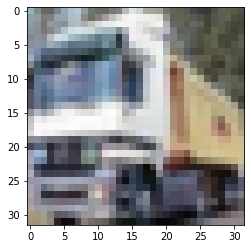

In [3]:
# 图像显示
import matplotlib.pyplot as plt
temp = train_data[1][0].numpy()
print(temp.shape)
plt.imshow(temp.transpose(1,2,0)) # 将输入调换为（32，32，3）
plt.show()

In [36]:
# 使用Dataloder进行分批
from torch.utils.data import DataLoader
BATCH_SIZE = 128
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE)

In [37]:
# 查看GPU是否可用
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [107]:
# 训练
def model_training(model, criterion, optimizer, epochs=5, verbose=False):
    import time
    # 定义device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    loss_list = []
    start = time.time()
    for epoch in range(epochs):
        start_each = time.time()
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # 前向传播
            outputs = model(inputs)
            # 计算损失函数
            loss = criterion(outputs, labels)
            # 梯度清零
            optimizer.zero_grad()
            # 反向传播
            loss.backward()
            # 参数更新
            optimizer.step()
        loss_list.append(loss.item())
        if verbose == True:
            print('epoch{} loss{: .4f} time{: .4f}'.format(epoch+1, loss.item(), time.time()-start_each))
    print('平均每个epoch训练时长：{: .4f}'.format((time.time()-start)/epochs))
    return loss_list, model    

In [67]:
# 测试
def model_test(model):
    model.eval() # 固定参数
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    correct, total = 0, 0
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 前向传播
        outputs = model(inputs)
        # 预测结果
        _, pred = torch.max(outputs.data, dim=1) # 取评分最高的类(dim=0是每列的最大值，dim=1是每行的最大值，返回两个值，一个是最大值tensor组一个是最大值所在的位置)
        # 对比结果与真实值
        total += labels.size()[0]
        correct += (pred==labels).sum().item()
    print('10000张测试图像的准确率为：{: .4f}%'.format(100*correct/total))      

In [113]:
# 定义超参数
EPOCHS = 50
LR = 0.01

# 定义损失函数
criterion = nn.CrossEntropyLoss()

In [114]:
# ResNet
print('ResNet18:')
resnet18 = torchvision.models.resnet18(pretrained=False)
optimizer = torch.optim.Adam(resnet18.parameters(), lr=LR)
loss_r18, resnet18 = model_training(resnet18, criterion, optimizer, epochs=EPOCHS)
model_test(resnet18)

ResNet18:
平均每个epoch训练时长： 18.6742
10000张测试图像的准确率为： 74.4200%


In [ ]:
# # 保存训练模型
# file_name = 'cifar10_resnet18.pt'
# torch.save(resnet18, file_name)
# print(file_name + ' saved')
# # 读取模型
# resnet18 = torch.load(file_name)

In [115]:
print('ResNet18(pretrained):')
resnet18_pre = torchvision.models.resnet18(pretrained=True)
optimizer = torch.optim.Adam(resnet18_pre.parameters(), lr=LR)
loss_r18_pre, resnet18_pre = model_training(resnet18_pre, criterion, optimizer, epochs=EPOCHS)
model_test(resnet18_pre)

ResNet18(pretrained):
平均每个epoch训练时长： 18.4726
10000张测试图像的准确率为： 74.7100%


In [116]:
print('ResNet34:')
resnet34 = torchvision.models.resnet34(pretrained=False)
optimizer = torch.optim.Adam(resnet34.parameters(), lr=LR)
loss_r34, resnet34 = model_training(resnet34, criterion, optimizer, epochs=EPOCHS)
model_test(resnet34)

ResNet34:
平均每个epoch训练时长： 27.3343
10000张测试图像的准确率为： 74.9000%


In [117]:
# DenseNet
print('DenseNet161:')
densenet161 = torchvision.models.densenet161(pretrained=False)
optimizer = torch.optim.Adam(densenet161.parameters(), lr=LR)
loss_d161, densenet161 = model_training(densenet161, criterion, optimizer, epochs=EPOCHS)
model_test(densenet161)

DenseNet161:
平均每个epoch训练时长： 71.9142
10000张测试图像的准确率为： 79.6800%


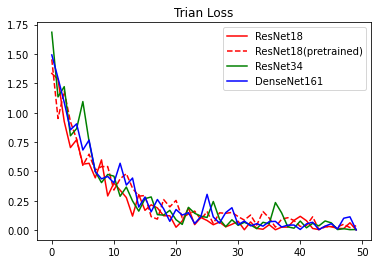

In [118]:
import numpy as np
x = np.arange(EPOCHS)
l_1 = plt.plot(x, np.array(loss_r18), c='red')
l_2 = plt.plot(x, np.array(loss_r18_pre), c='red',linestyle='--')
l_3 = plt.plot(x, np.array(loss_r34), c='green')
l_4 = plt.plot(x, np.array(loss_d161), c='blue')
plt.legend(['ResNet18','ResNet18(pretrained)','ResNet34','DenseNet161'])
plt.title('Trian Loss')
plt.show()